--- Part 1: Calculating & Saving Global Mean (Climatology) ---
Global Mean data successfully saved to D:\IPMA\Results\global_mean_meteo_Iberia.nc.

--- Part 2: Compositing Analysis and Saving Composites ---

[CO] Pollutant concentration ranges (N=25)
  High days: min = 376.18, max = 1739.84 (unknown)
  Low  days: min = 96.12, max = 108.01 (unknown)

[NO] Pollutant concentration ranges (N=25)
  High days: min = 8.19, max = 34.60 (unknown)
  Low  days: min = 0.05, max = 0.08 (unknown)

[NO2] Pollutant concentration ranges (N=25)
  High days: min = 14.81, max = 24.08 (unknown)
  Low  days: min = 1.76, max = 2.21 (unknown)

[PM2.5] Pollutant concentration ranges (N=25)
  High days: min = 51.90, max = 128.79 (unknown)
  Low  days: min = 2.22, max = 3.41 (unknown)

[PM10] Pollutant concentration ranges (N=25)
  High days: min = 69.26, max = 172.57 (unknown)
  Low  days: min = 3.40, max = 5.22 (unknown)
Data processing complete. Starting visualizations.

--- Part 3: Generating Visualization P

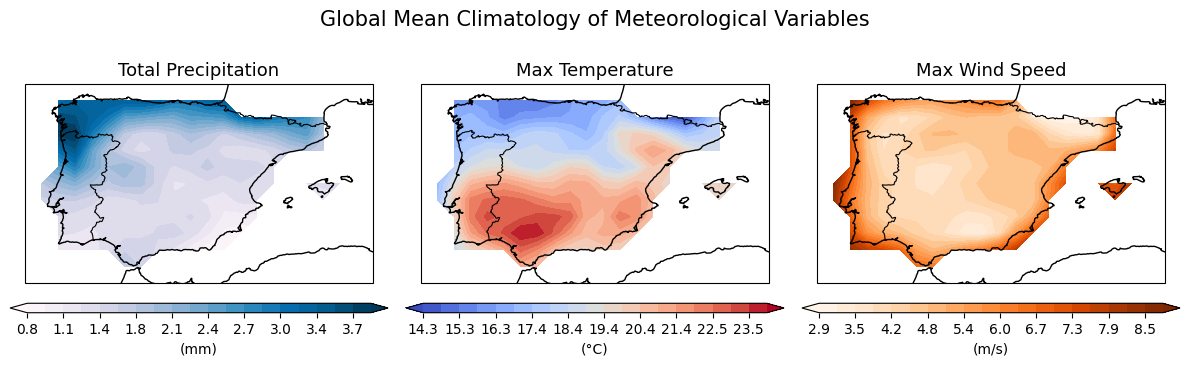

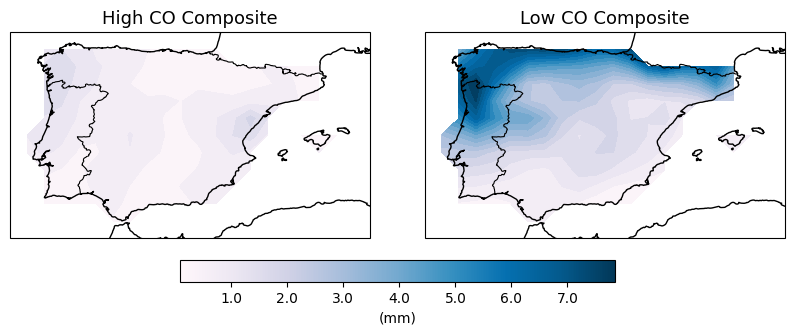

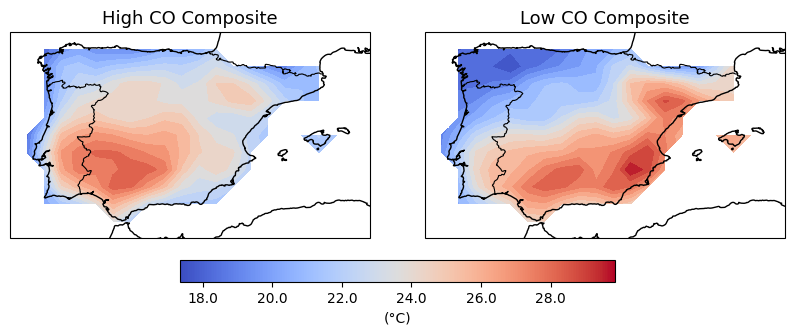

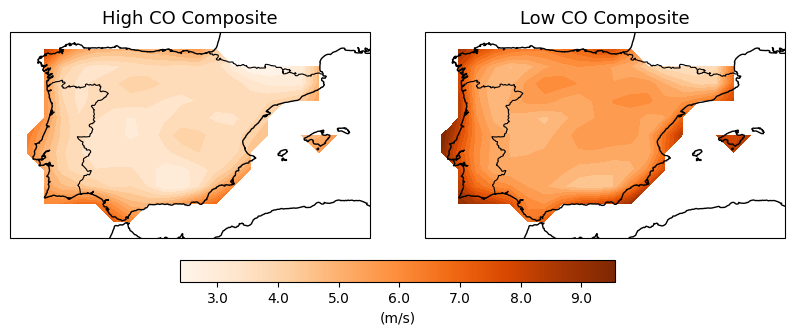

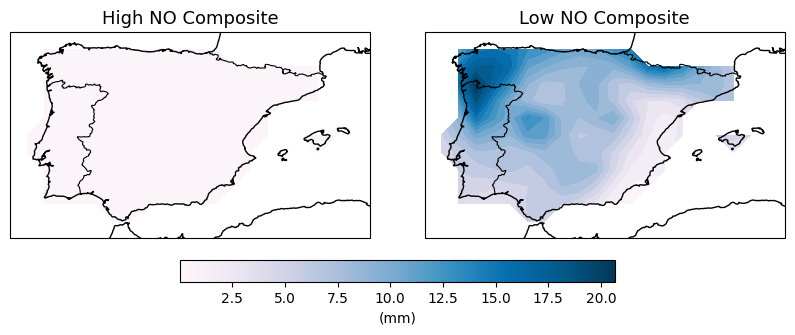

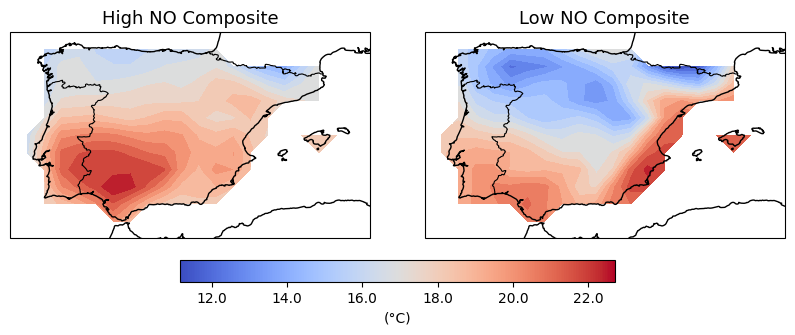

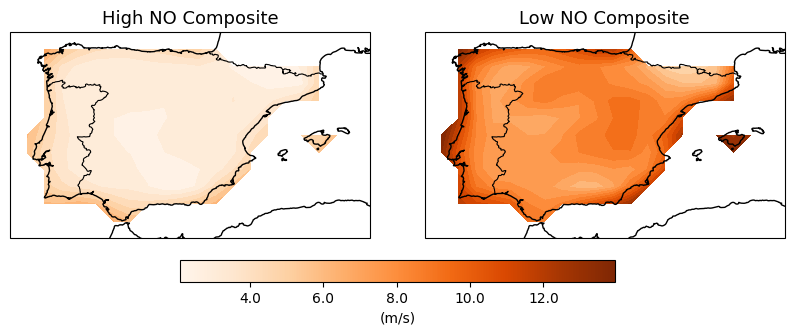

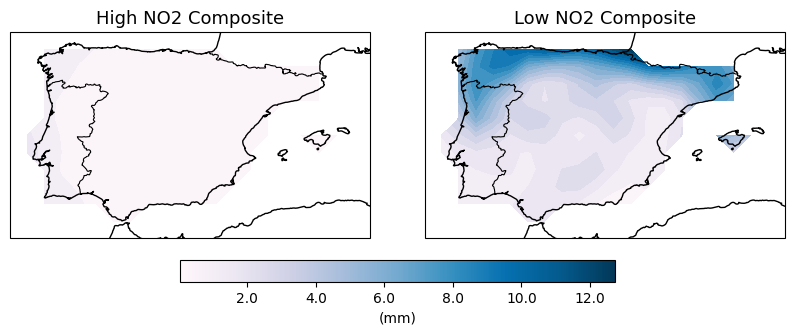

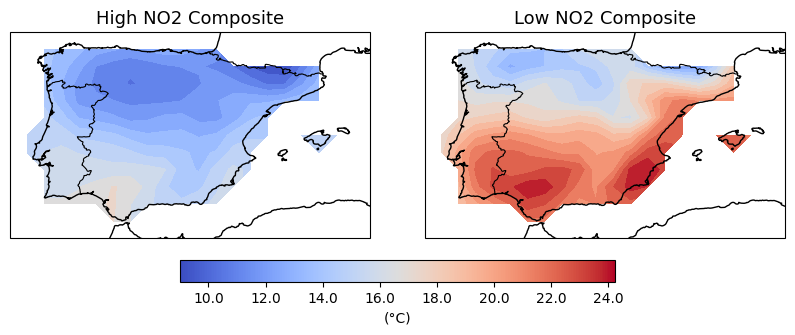

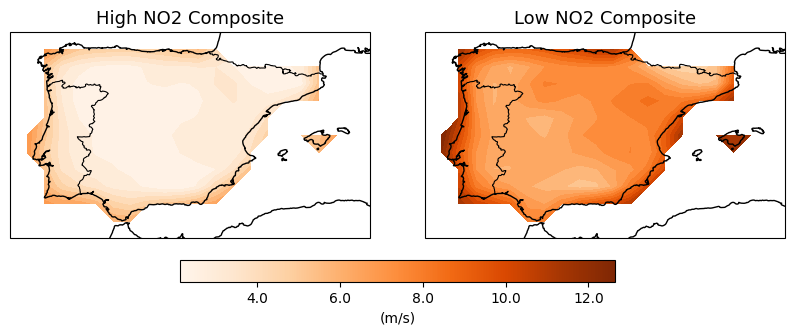

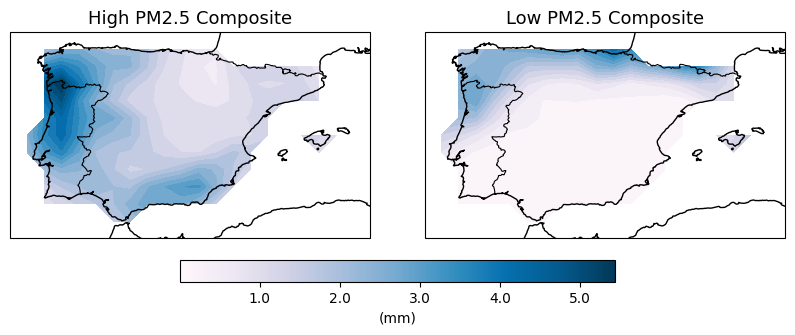

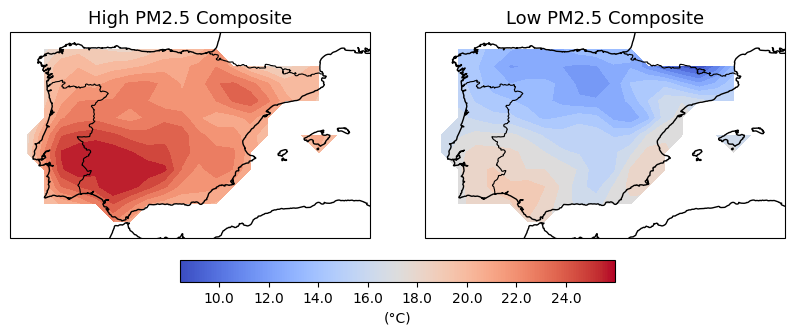

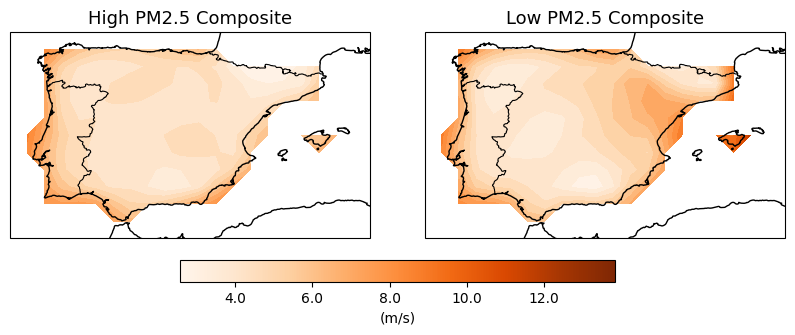

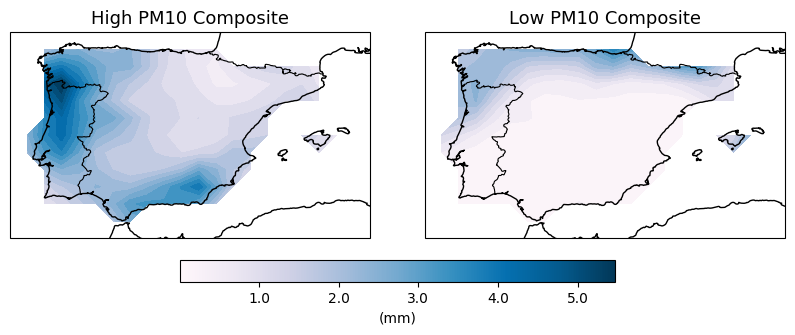

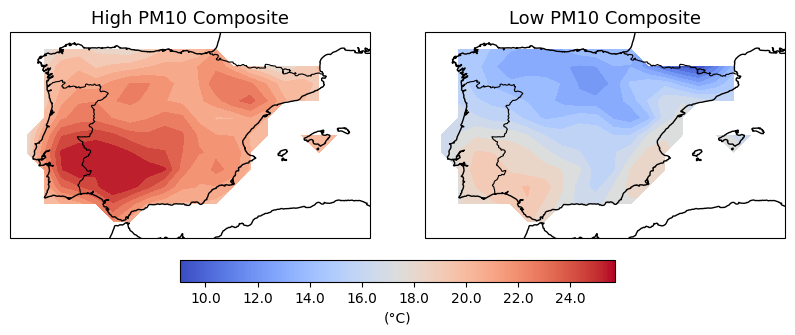

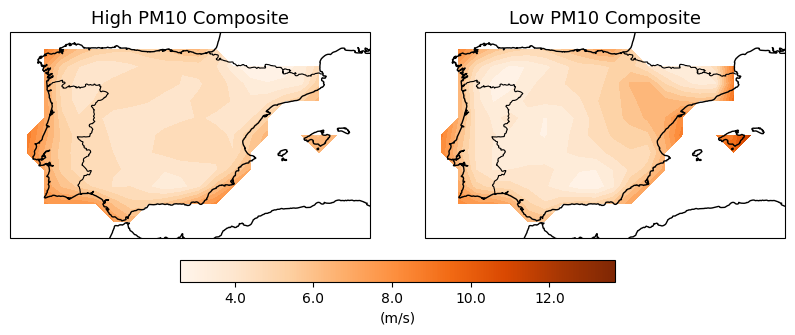

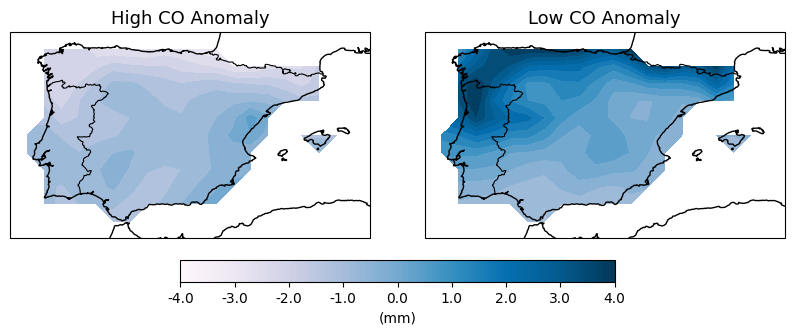

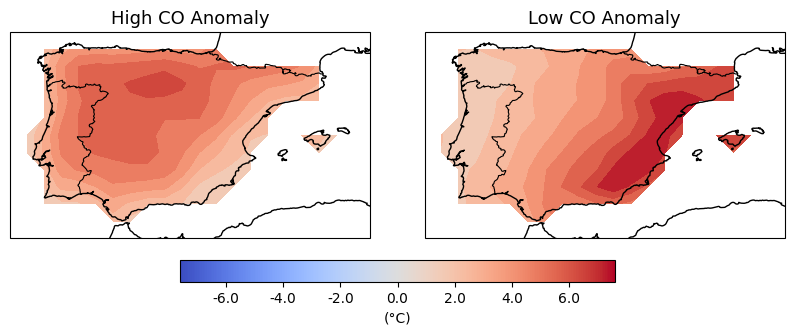

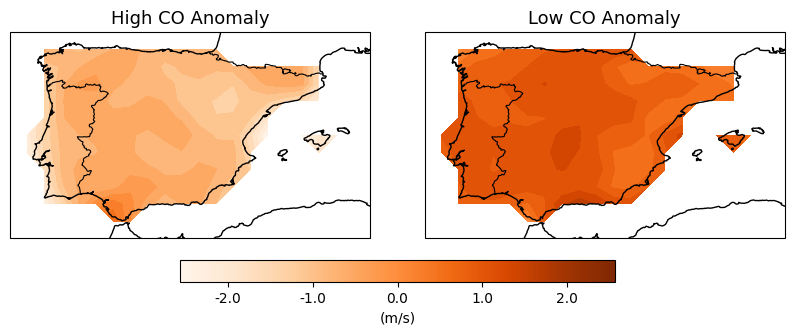

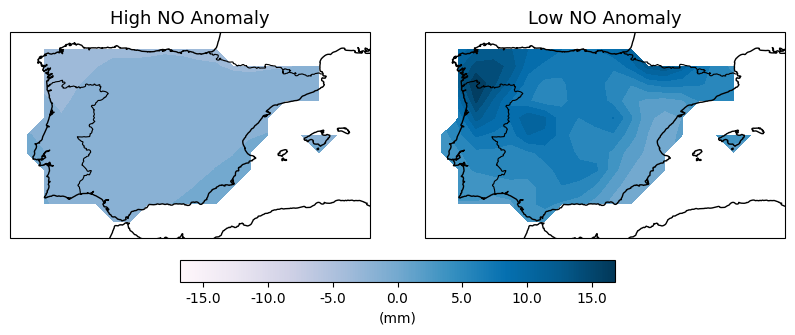

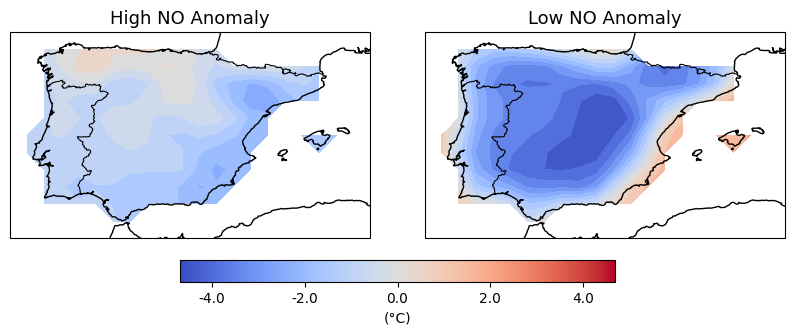

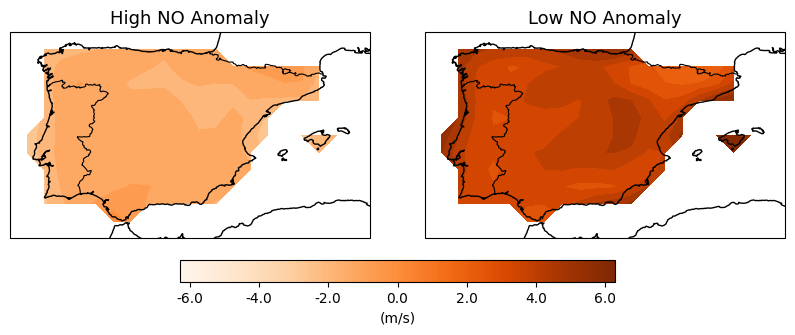

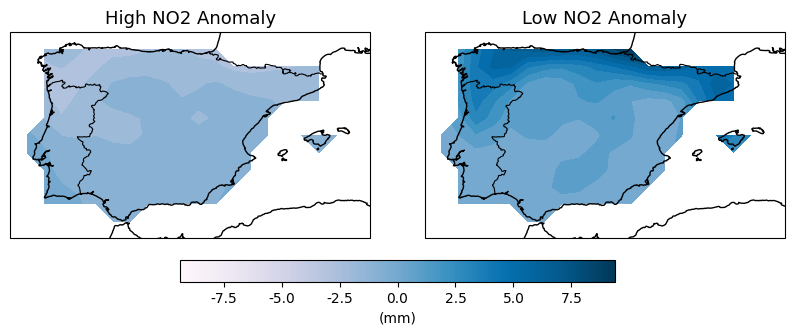

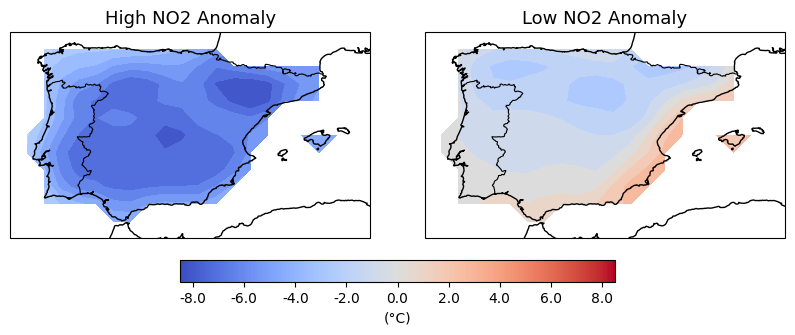

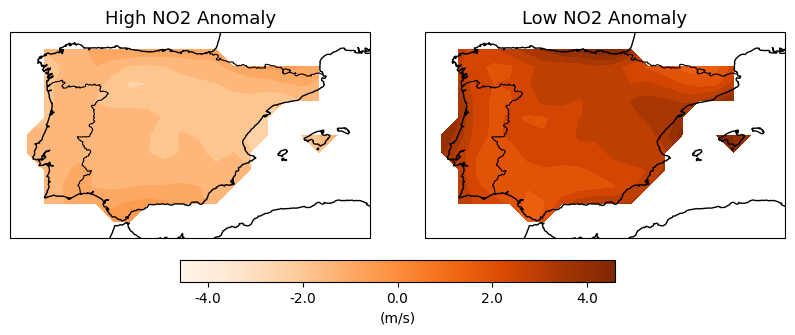

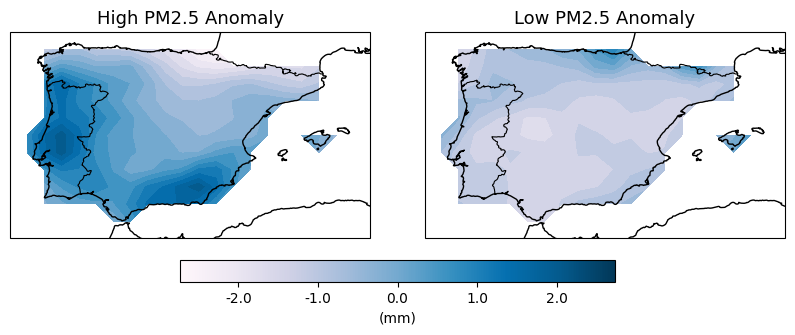

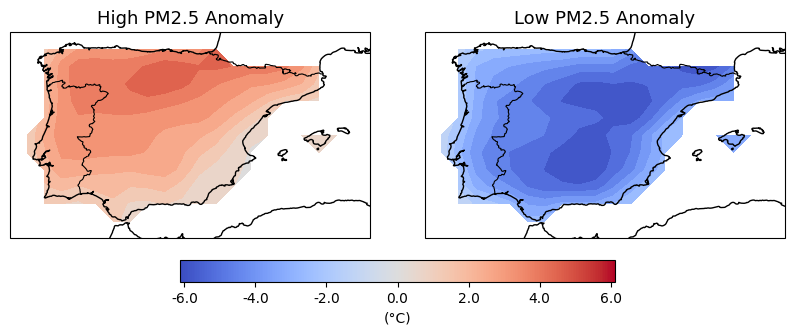

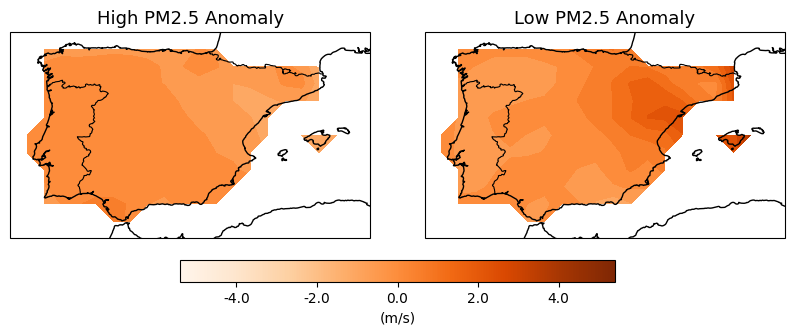

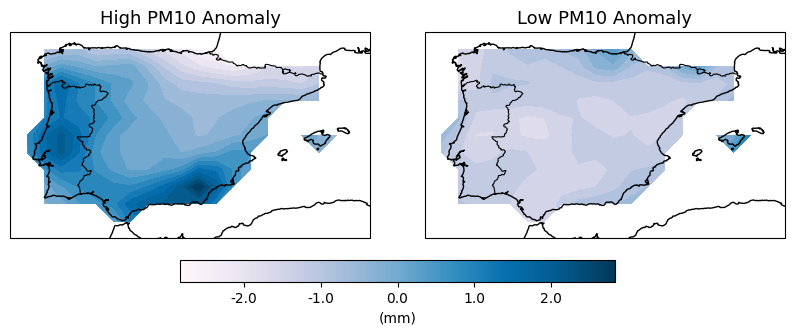

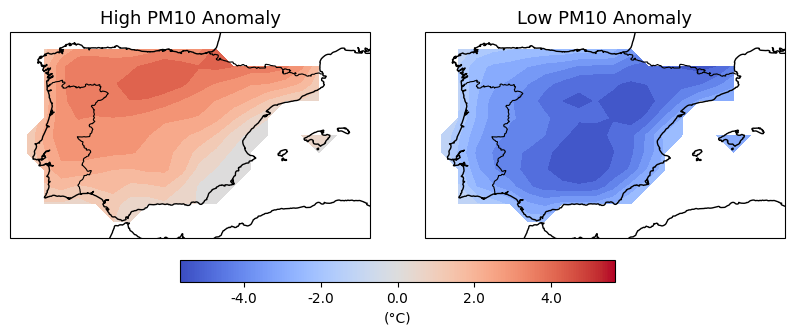

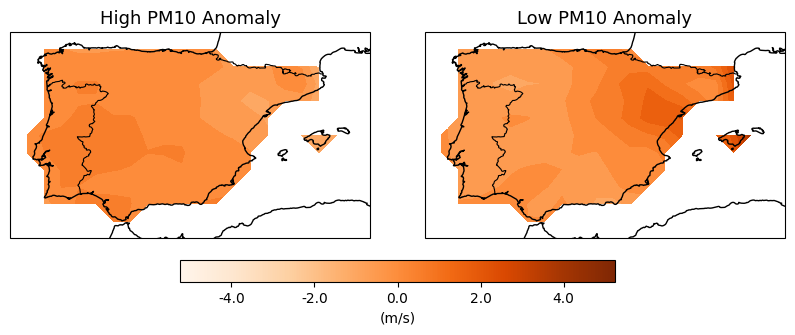


Code execution finished. Composites and Anomalies now plotted without difference fields.


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter

# ------------------------------
# USER INPUTS
# ------------------------------

pollutant_files = {
    'CO':    r"D:\IPMA\Results\co_fire_meteo_Greece.nc",
    'NO':    r"D:\IPMA\Results\no_fire_meteo_Greece.nc",
    'NO2':   r"D:\IPMA\Results\no2_fire_meteo_Greece.nc",
    'PM2.5': r"D:\IPMA\Results\pm2p5_fire_meteo_Greece.nc",
    'PM10':  r"D:\IPMA\Results\pm10_fire_meteo_Greece.nc"
}

N_days = 25

meteo_vars = {
    "precip_Total_Precipitation": ("mm", "PuBu"),
    "temp_Max": ("°C", "coolwarm"),
    "wind_Max": ("m/s", "Oranges")
}

meteo_var_names = {
    "precip_Total_Precipitation": "Total Precipitation",
    "temp_Max": "Max Temperature",
    "wind_Max": "Max Wind Speed"
}

global_mean_output_file = r"D:\IPMA\Results\global_mean_meteo_Greece.nc" 
composite_output_dir = r"D:\IPMA\Results"

# --- Helper functions ---
def apply_unit_conversions(ds, pollutant_name):
    if pollutant_name == 'CO' and 'Mean' in ds:
        ds['Mean'] = ds['Mean'] * 1000
        if 'units' in ds['Mean'].attrs and ds['Mean'].attrs['units'] == 'mg/m3':
            ds['Mean'].attrs['units'] = 'µg/m3'
    
    precip_var = "precip_Total_Precipitation"
    if precip_var in ds:
        ds[precip_var] = ds[precip_var] * 1000
        if 'units' in ds[precip_var].attrs and ds[precip_var].attrs['units'] == 'm':
            ds[precip_var].attrs['units'] = 'mm'

    return ds

def set_composite_attrs(da, comp_type, var_name, pollutant, unit, N_days):
    da.name = f'{var_name}_{comp_type}'
    da.attrs['units'] = unit
    da.attrs['long_name'] = f'{comp_type} Composite of {meteo_var_names[var_name]} based on {pollutant} extremes'
    da.attrs['N_days'] = N_days
    return da

def calculate_dynamic_extent(data_array):
    mask = np.isfinite(data_array.values)
    if not mask.any(): return None

    lat_vals = data_array["latitude"].values
    lon_vals = data_array["longitude"].values

    valid_idx = np.where(mask)
    unique_lat_idx = np.unique(valid_idx[0])
    unique_lon_idx = np.unique(valid_idx[1])

    lat_step = lat_vals[1] - lat_vals[0] if len(lat_vals) > 1 else 0.5
    lon_step = lon_vals[1] - lon_vals[0] if len(lon_vals) > 1 else 0.5

    lat_min_ext = max(lat_vals[unique_lat_idx].min() - lat_step, lat_vals.min())
    lat_max_ext = min(lat_vals[unique_lat_idx].max() + lat_step, lat_vals.max())
    lon_min_ext = max(lon_vals[unique_lon_idx].min() - lon_step, lon_vals.min())
    lon_max_ext = min(lon_vals[unique_lon_idx].max() + lon_step, lon_vals.max())
    
    return [lon_min_ext, lon_max_ext, lat_min_ext, lat_max_ext]

# ------------------------------
# PART 1: GLOBAL MEAN CALCULATION
# ------------------------------

print("--- Part 1: Calculating & Saving Global Mean (Climatology) ---")
reference_pollutant = 'CO'
reference_file = pollutant_files[reference_pollutant]

try:
    ds_ref = xr.open_dataset(reference_file)
except FileNotFoundError:
    print(f"ERROR: Reference file not found at {reference_file}. Exiting.")
    exit()

ds_ref = apply_unit_conversions(ds_ref, reference_pollutant)
global_means = {}
for var_name, (unit, cmap) in meteo_vars.items():
    mean_da = ds_ref[var_name].mean(dim='time')
    mean_da.attrs['units'] = unit
    mean_da.attrs['long_name'] = f'Time-Mean of {meteo_var_names[var_name]}'
    global_means[var_name] = mean_da

ds_global_mean = xr.Dataset(global_means)
output_dir = os.path.dirname(global_mean_output_file)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
ds_global_mean.to_netcdf(global_mean_output_file, mode='w')
print(f"Global Mean data successfully saved to {global_mean_output_file}.")

# ------------------------------
# PART 2: COMPOSITING & ANOMALY CALCULATION
# ------------------------------

print("\n--- Part 2: Compositing Analysis and Saving Composites ---")
if not os.path.exists(composite_output_dir):
    os.makedirs(composite_output_dir)

all_composite_results = {}

for target_pollutant, target_file in pollutant_files.items():
    
    try:
        ds = xr.open_dataset(target_file)
    except FileNotFoundError:
        print(f"Skipping {target_pollutant}: File not found at {target_file}")
        continue
        
    ds = apply_unit_conversions(ds, target_pollutant)
        
    pollutant_time_series = ds['Mean'].mean(dim=['latitude', 'longitude'])
    ranked_series = pollutant_time_series.to_series().sort_values(ascending=False)
    high_days_time_stamps = ranked_series.index[:N_days]
    low_days_time_stamps = ranked_series.index[-N_days:]

    # --------------------------------------------------
    # PRINT RANGE OF POLLUTANT CONCENTRATIONS (High / Low)
    # --------------------------------------------------

    # Extract pollutant concentrations for selected days
    high_vals = ds['Mean'].sel(time=high_days_time_stamps)
    low_vals  = ds['Mean'].sel(time=low_days_time_stamps)

    # Spatial mean for each selected day
    high_vals_mean = high_vals.mean(dim=['latitude', 'longitude'])
    low_vals_mean  = low_vals.mean(dim=['latitude', 'longitude'])

    # Compute ranges
    high_min = float(high_vals_mean.min().values)
    high_max = float(high_vals_mean.max().values)
    low_min  = float(low_vals_mean.min().values)
    low_max  = float(low_vals_mean.max().values)

    units = ds['Mean'].attrs.get('units', 'unknown')

    print(f"\n[{target_pollutant}] Pollutant concentration ranges (N={N_days})")
    print(f"  High days: min = {high_min:.2f}, max = {high_max:.2f} ({units})")
    print(f"  Low  days: min = {low_min:.2f}, max = {low_max:.2f} ({units})")

    composite_data_vars = {} 
    composite_results_pollutant = {}

    for var_name, (unit, cmap) in meteo_vars.items():
        
        # Composites
        high_composite = ds[var_name].sel(time=high_days_time_stamps).mean(dim='time')
        low_composite = ds[var_name].sel(time=low_days_time_stamps).mean(dim='time')
        
        # Anomalies
        global_mean_data = global_means[var_name]
        high_anomaly = high_composite - global_mean_data 
        low_anomaly = low_composite - global_mean_data  

        # Store results for plotting
        composite_results_pollutant[var_name] = {
            'High_Comp': high_composite, 
            'Low_Comp': low_composite,   
            'High_Anomaly': high_anomaly,
            'Low_Anomaly': low_anomaly,
            'unit': unit,
            'cmap': cmap
        }

        # Store all generated fields for NetCDF saving
        composite_data_vars[f'{var_name}_High_Comp'] = set_composite_attrs(high_composite.copy(), 'High_Comp', var_name, target_pollutant, unit, N_days)
        composite_data_vars[f'{var_name}_Low_Comp'] = set_composite_attrs(low_composite.copy(), 'Low_Comp', var_name, target_pollutant, unit, N_days)
        composite_data_vars[f'{var_name}_High_Anom'] = set_composite_attrs(high_anomaly.copy(), 'High_Anom', var_name, target_pollutant, unit, N_days)
        composite_data_vars[f'{var_name}_Low_Anom'] = set_composite_attrs(low_anomaly.copy(), 'Low_Anom', var_name, target_pollutant, unit, N_days)

    all_composite_results[target_pollutant] = composite_results_pollutant
    
    # Save composites to NetCDF
    composite_file_name = f"{target_pollutant}_composite_meteo_Greece.nc"
    output_path = os.path.join(composite_output_dir, composite_file_name)
    ds_composite = xr.Dataset(
        composite_data_vars,
        coords={'latitude': high_composite['latitude'], 'longitude': high_composite['longitude']}
    )
    ds_composite.attrs['title'] = f'Composite Analysis for {target_pollutant} Extremes (N={N_days})'
    ds_composite.to_netcdf(output_path, mode='w')
    
print("Data processing complete. Starting visualizations.")

from matplotlib.ticker import FormatStrFormatter

from matplotlib.ticker import FormatStrFormatter

# ------------------------------
# PART 3: VISUALIZATION (contourf)
# ------------------------------

print("\n--- Part 3: Generating Visualization Plots (contourf, single colorbar, 1 decimal) ---")
num_cols = len(meteo_vars)
meteo_list = list(meteo_vars.keys())

reference_data_for_extent = ds_global_mean[meteo_list[0]]
global_extent = calculate_dynamic_extent(reference_data_for_extent)
if global_extent is None:
    global_extent = [ds_global_mean.longitude.min().item(), ds_global_mean.longitude.max().item(), 
                     ds_global_mean.latitude.min().item(), ds_global_mean.latitude.max().item()]

TITLE_FONT_SIZE = 15
SUBTITLE_FONT_SIZE = 13
AXIS_FONT_SIZE = 11
CBAR_FONT_SIZE = 10
NUM_LEVELS = 20  # number of contour levels

# --- Global Mean Climatologies ---
fig1, axes1 = plt.subplots(
    1, num_cols, figsize=(4 * num_cols, 3.5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
if num_cols == 1: axes1 = [axes1]

for i, var_name in enumerate(meteo_list):
    ax = axes1[i]
    mean_data = global_means[var_name]
    unit, cmap = meteo_vars[var_name]
    var_display_name = meteo_var_names[var_name]

    lons, lats = np.meshgrid(mean_data['longitude'], mean_data['latitude'])
    levels = np.linspace(np.nanmin(mean_data.values), np.nanmax(mean_data.values), NUM_LEVELS)
    
    plot = ax.contourf(
        lons, lats, mean_data.values,
        levels=levels, cmap=cmap, extend='both', transform=ccrs.PlateCarree()
    )
    ax.set_extent(global_extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.8)
    ax.set_title(f"{var_display_name}", fontsize=SUBTITLE_FONT_SIZE)
    ax.set_xlabel("Longitude", fontsize=AXIS_FONT_SIZE)
    ax.set_ylabel("Latitude", fontsize=AXIS_FONT_SIZE)

    cbar = fig1.colorbar(plot, ax=ax, orientation='horizontal', pad=0.08, aspect=40)
    cbar.set_label(f"({unit})", fontsize=CBAR_FONT_SIZE)
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.ax.tick_params(labelsize=CBAR_FONT_SIZE)

fig1.suptitle("Global Mean Climatology of Meteorological Variables", fontsize=TITLE_FONT_SIZE, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Raw Composites ---
for pollutant in pollutant_files.keys():
    if pollutant not in all_composite_results:
        continue

    for var_name in meteo_list:
        result = all_composite_results[pollutant][var_name]

        high_comp = result['High_Comp']
        low_comp = result['Low_Comp']
        unit, cmap = result['unit'], result['cmap']
        var_display_name = meteo_var_names[var_name]

        vmin = np.nanmin([high_comp.values, low_comp.values])
        vmax = np.nanmax([high_comp.values, low_comp.values])
        levels = np.linspace(vmin, vmax, NUM_LEVELS)

        fig, axes = plt.subplots(
            1, 2, figsize=(10, 4),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        # --- High composite ---
        lons, lats = np.meshgrid(high_comp.longitude, high_comp.latitude)
        axes[0].contourf(
            lons, lats, high_comp,
            levels=levels, cmap=cmap, extend='both',
            transform=ccrs.PlateCarree()
        )
        axes[0].set_title(f"High {pollutant} Composite", fontsize=SUBTITLE_FONT_SIZE)
        axes[0].set_extent(global_extent)
        axes[0].coastlines()
        axes[0].add_feature(cfeature.BORDERS, linewidth=0.8)
        axes[0].set_ylabel("Latitude")

        # --- Low composite ---
        lons, lats = np.meshgrid(low_comp.longitude, low_comp.latitude)
        axes[1].contourf(
            lons, lats, low_comp,
            levels=levels, cmap=cmap, extend='both',
            transform=ccrs.PlateCarree()
        )
        axes[1].set_title(f"Low {pollutant} Composite", fontsize=SUBTITLE_FONT_SIZE)
        axes[1].set_extent(global_extent)
        axes[1].coastlines()
        axes[1].add_feature(cfeature.BORDERS, linewidth=0.8)

        # 🔑 Reserve space BEFORE colorbar
        fig.subplots_adjust(bottom=0.22, top=0.90, wspace=0.15)

        # --- Shared colorbar (always below maps) ---
        cbar = fig.colorbar(
            cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
            ax=axes,
            orientation='horizontal',
            fraction=0.08,
            pad=0.08
        )
        cbar.set_label(f"({unit})", fontsize=CBAR_FONT_SIZE)
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar.ax.tick_params(labelsize=CBAR_FONT_SIZE)

        fig.suptitle( f"{var_display_name}", fontsize=TITLE_FONT_SIZE )

        plt.show()


# --- Composite Anomalies ---
for pollutant in pollutant_files.keys():
    if pollutant not in all_composite_results:
        continue

    for var_name in meteo_list:
        result = all_composite_results[pollutant][var_name]

        high_anom = result['High_Anomaly']
        low_anom = result['Low_Anomaly']
        unit, cmap = result['unit'], result['cmap']
        var_display_name = meteo_var_names[var_name]

        vmax = np.nanmax(np.abs([high_anom.values, low_anom.values]))
        levels = np.linspace(-vmax, vmax, NUM_LEVELS)

        fig, axes = plt.subplots(
            1, 2, figsize=(10, 4),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        # --- High anomaly ---
        lons, lats = np.meshgrid(high_anom.longitude, high_anom.latitude)
        axes[0].contourf(
            lons, lats, high_anom,
            levels=levels, cmap=cmap, extend='both',
            transform=ccrs.PlateCarree()
        )
        axes[0].set_title(f"High {pollutant} Anomaly", fontsize=SUBTITLE_FONT_SIZE)
        axes[0].set_extent(global_extent)
        axes[0].coastlines()
        axes[0].add_feature(cfeature.BORDERS, linewidth=0.8)
        axes[0].set_ylabel("Latitude")

        # --- Low anomaly ---
        lons, lats = np.meshgrid(low_anom.longitude, low_anom.latitude)
        axes[1].contourf(
            lons, lats, low_anom,
            levels=levels, cmap=cmap, extend='both',
            transform=ccrs.PlateCarree()
        )
        axes[1].set_title(f"Low {pollutant} Anomaly", fontsize=SUBTITLE_FONT_SIZE)
        axes[1].set_extent(global_extent)
        axes[1].coastlines()
        axes[1].add_feature(cfeature.BORDERS, linewidth=0.8)

        # 🔑 Reserve space BEFORE colorbar
        fig.subplots_adjust(bottom=0.22, top=0.90, wspace=0.15)

        # --- Shared anomaly colorbar ---
        cbar = fig.colorbar(
            cm.ScalarMappable(norm=colors.Normalize(vmin=-vmax, vmax=vmax), cmap=cmap),
            ax=axes,
            orientation='horizontal',
            fraction=0.08,
            pad=0.08
        )
        cbar.set_label(f"({unit})", fontsize=CBAR_FONT_SIZE)
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        cbar.ax.tick_params(labelsize=CBAR_FONT_SIZE)

        fig.suptitle( f"{var_display_name}", fontsize=TITLE_FONT_SIZE )

        plt.show()


print("\nCode execution finished. Composites and Anomalies now plotted without difference fields.")


--- Part 1: Calculating & Saving Global Mean (Climatology) ---
Global Mean data successfully saved to D:\IPMA\Results\global_mean_meteo_Iberia.nc.

--- Part 2: Compositing Analysis and Saving Composites ---

[CO] Pollutant concentration ranges (N=25)
  High days: min = 376.18, max = 1739.84 (unknown)
  Low  days: min = 96.12, max = 108.01 (unknown)

[NO] Pollutant concentration ranges (N=25)
  High days: min = 8.19, max = 34.60 (unknown)
  Low  days: min = 0.05, max = 0.08 (unknown)

[NO2] Pollutant concentration ranges (N=25)
  High days: min = 14.81, max = 24.08 (unknown)
  Low  days: min = 1.76, max = 2.21 (unknown)

[PM2.5] Pollutant concentration ranges (N=25)
  High days: min = 51.90, max = 128.79 (unknown)
  Low  days: min = 2.22, max = 3.41 (unknown)

[PM10] Pollutant concentration ranges (N=25)
  High days: min = 69.26, max = 172.57 (unknown)
  Low  days: min = 3.40, max = 5.22 (unknown)
Data processing complete. Starting visualizations.

--- Part 3: Generating Visualization P

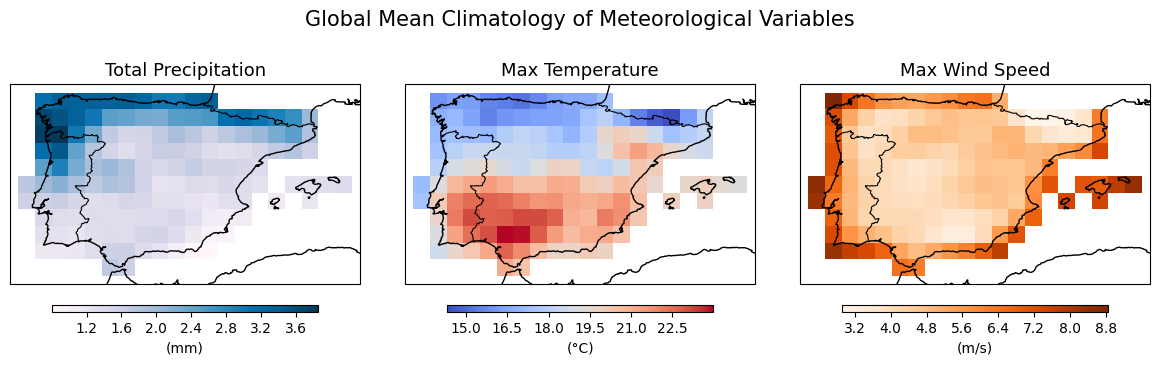

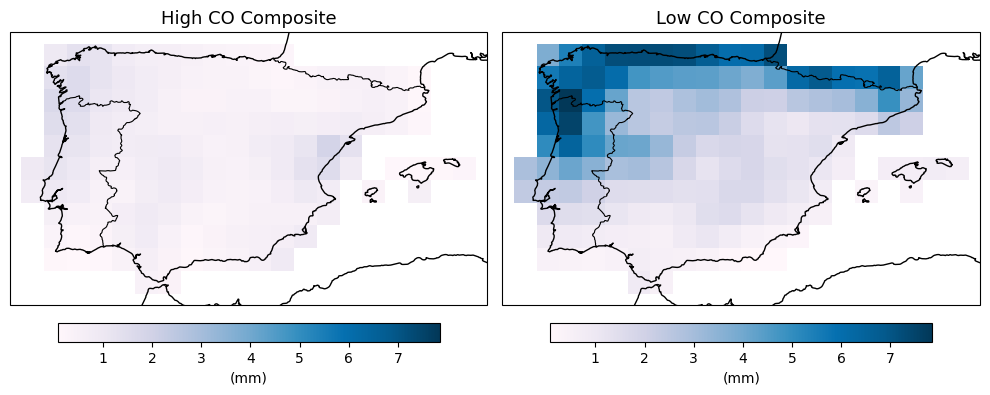

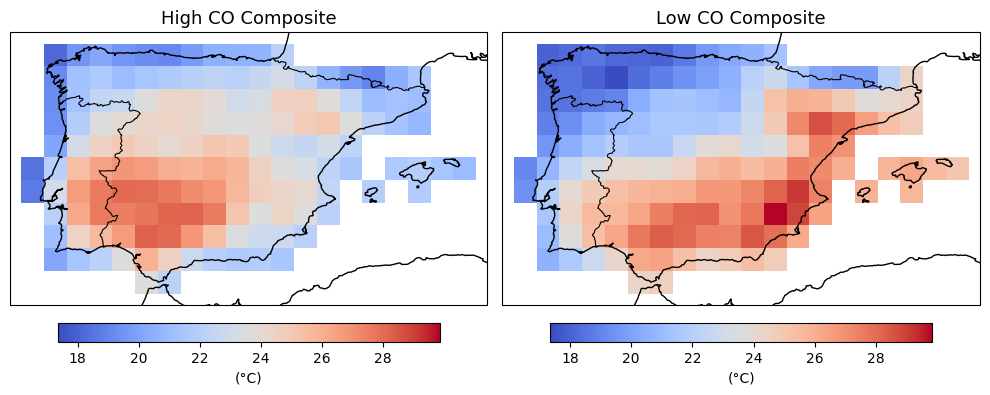

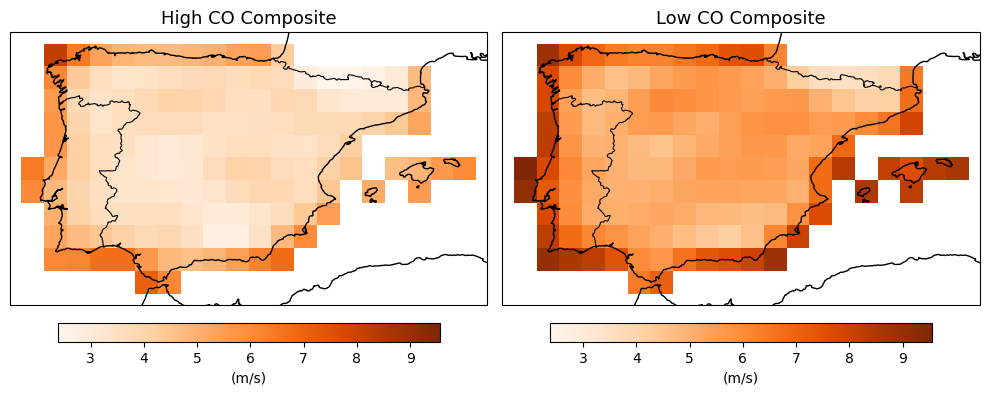

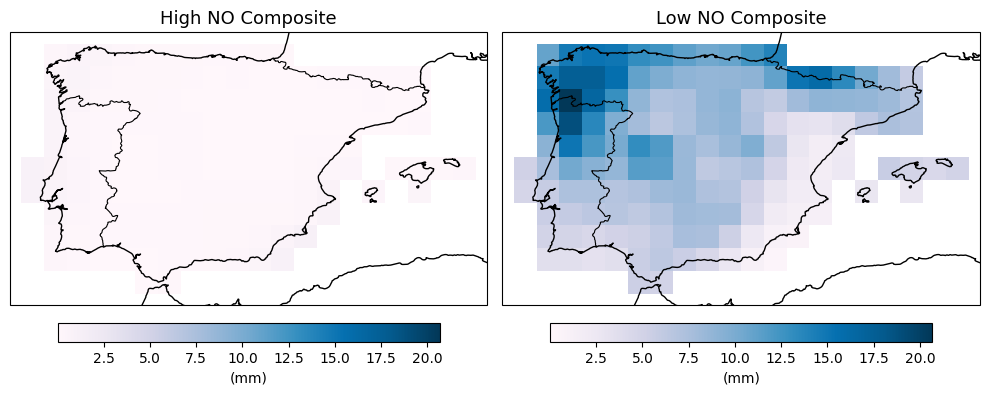

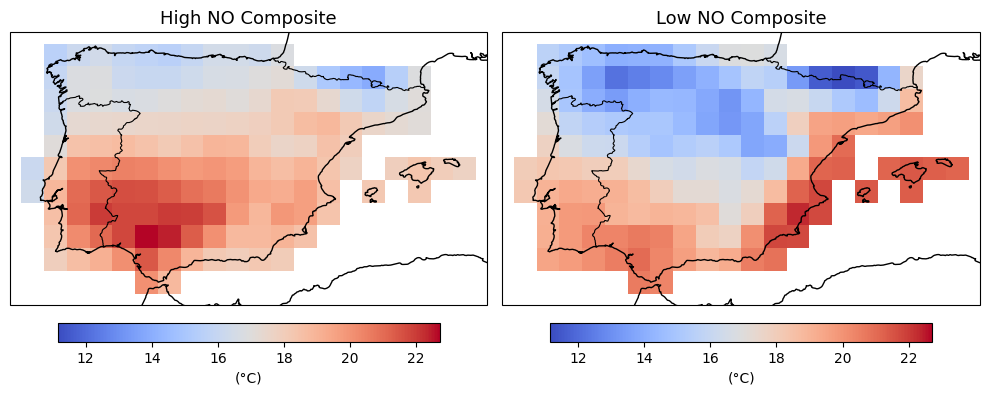

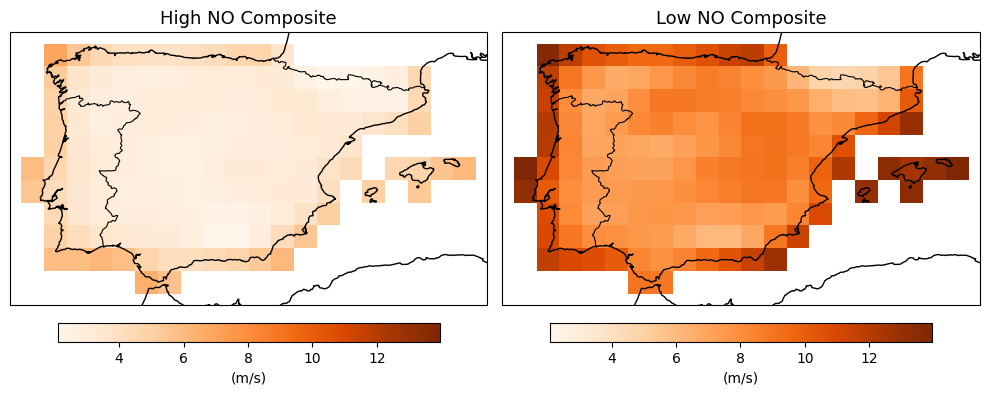

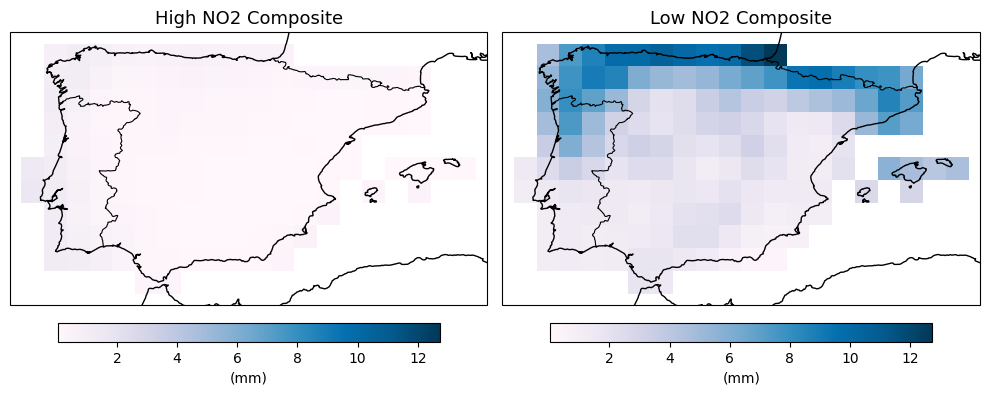

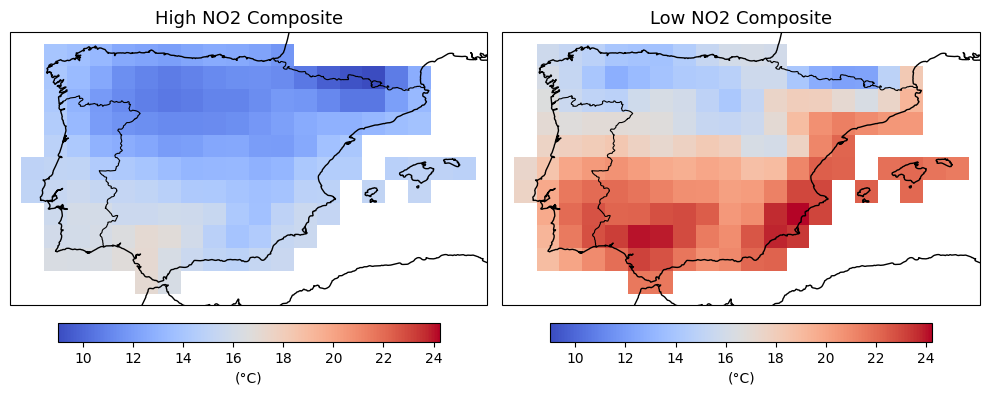

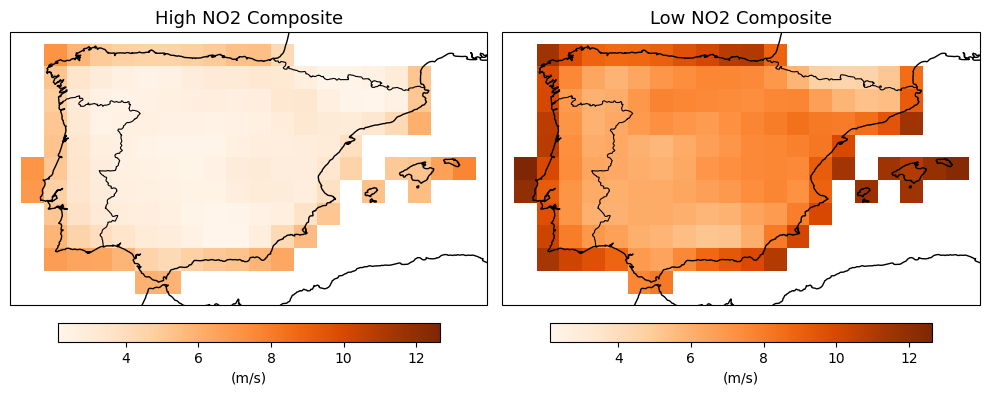

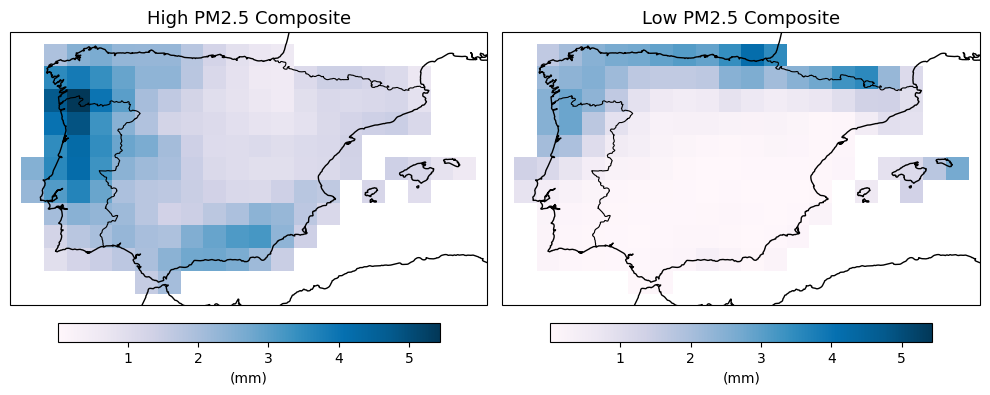

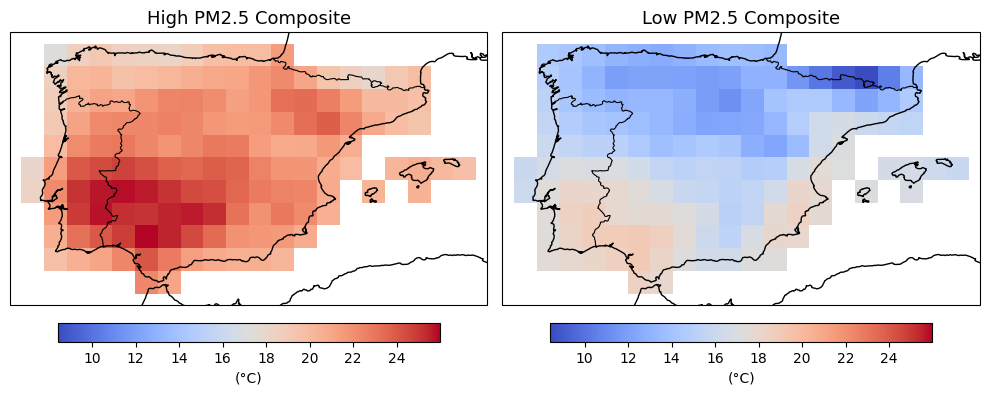

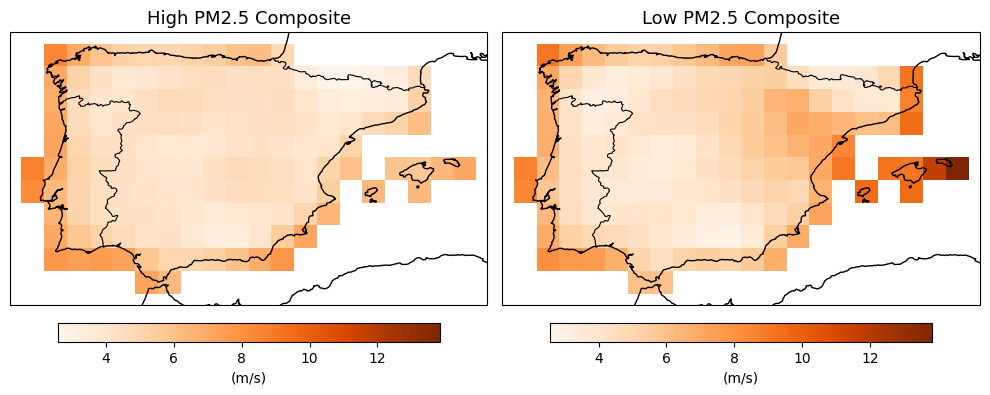

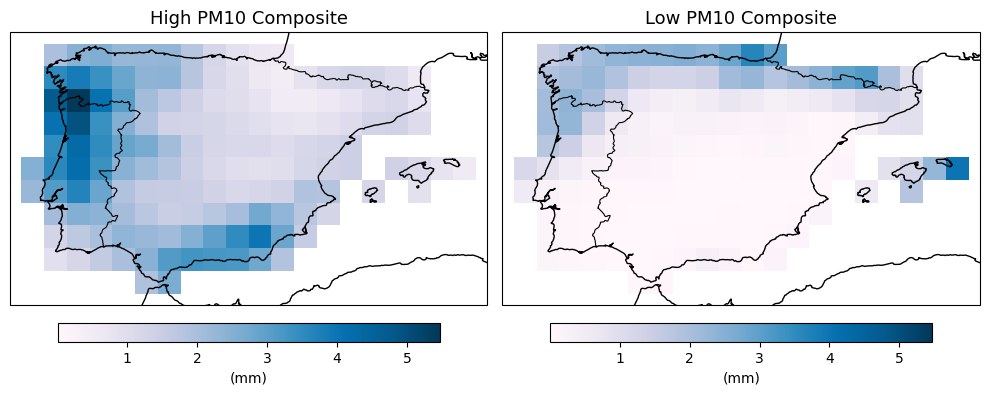

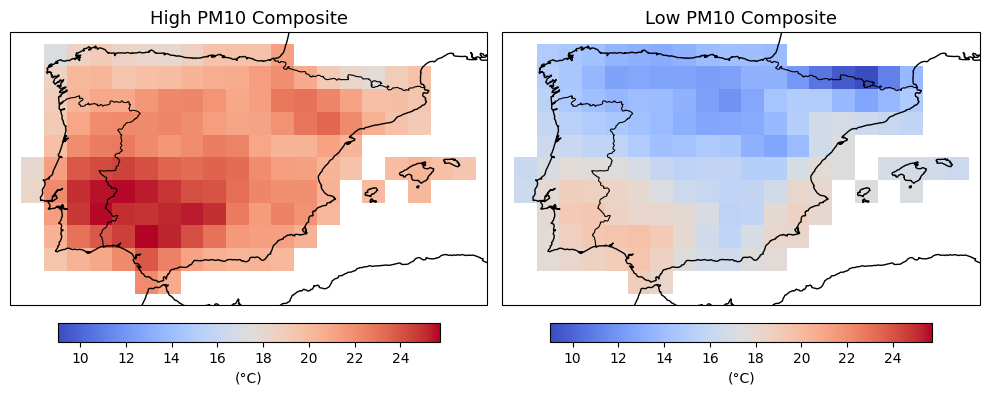

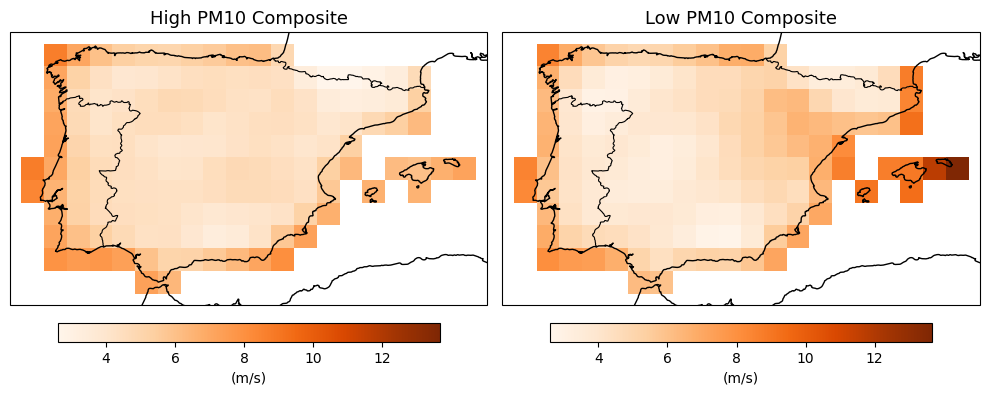

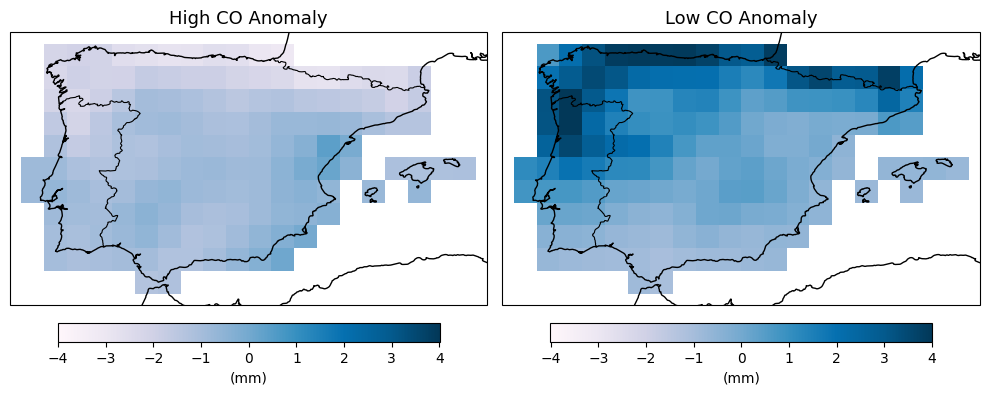

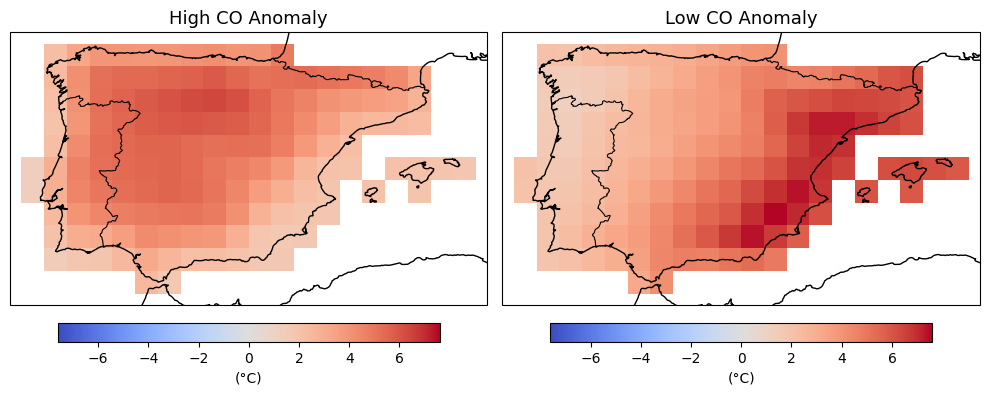

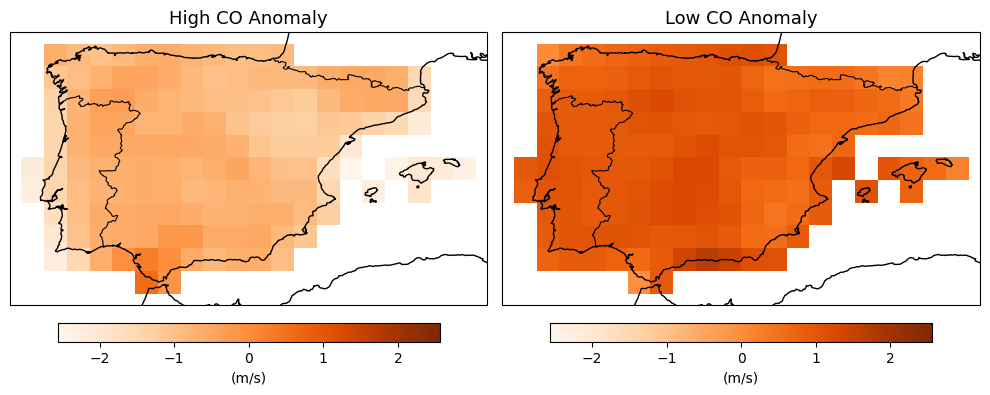

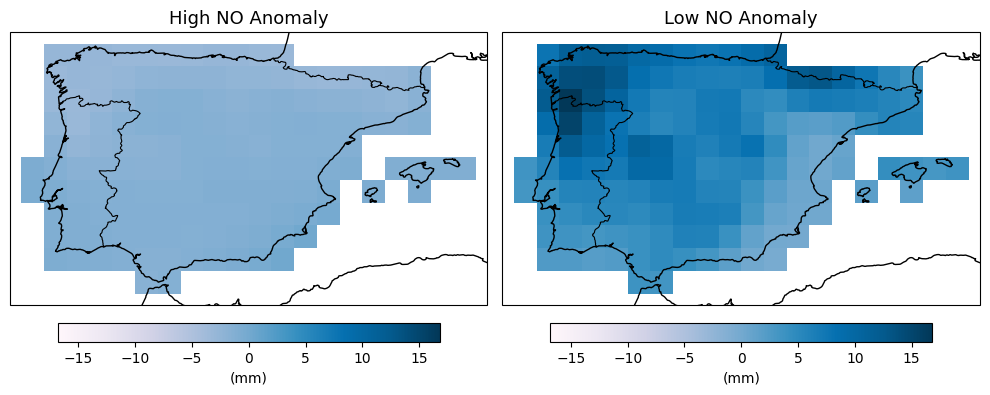

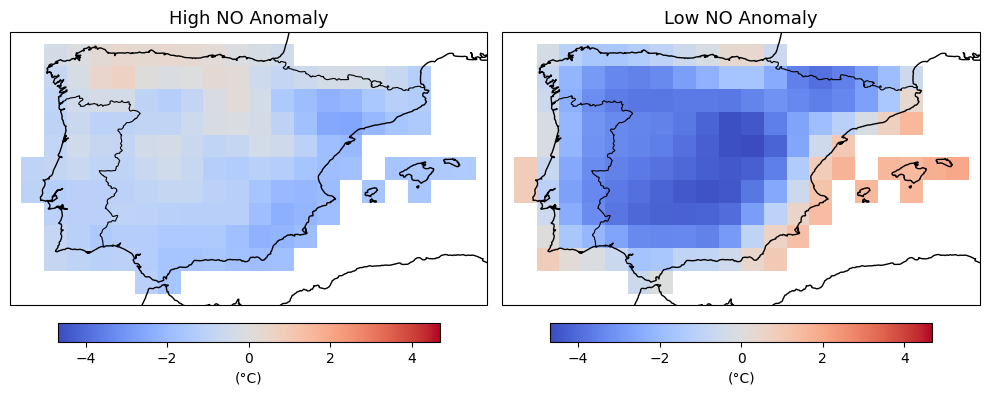

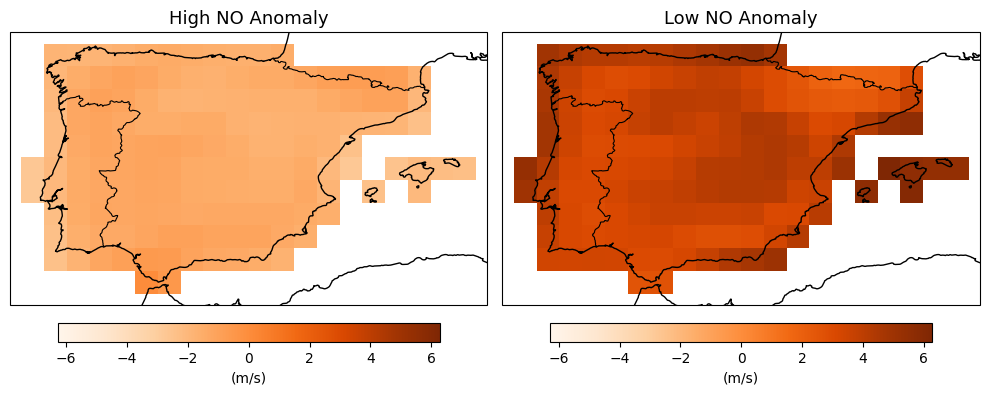

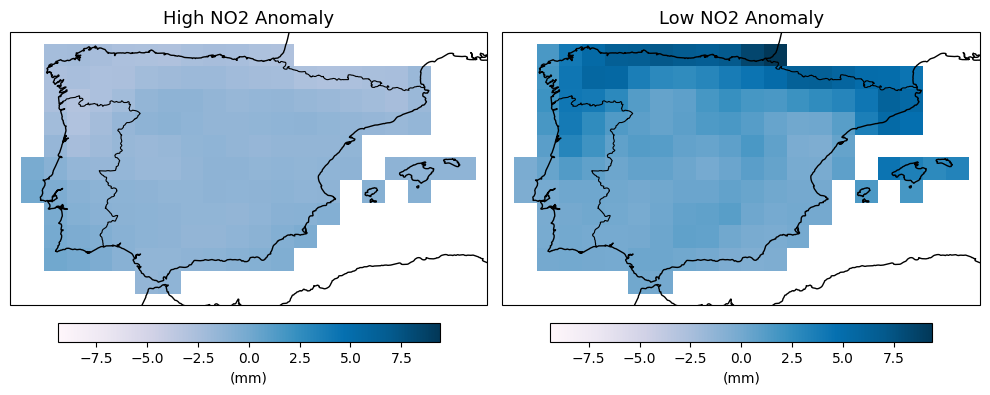

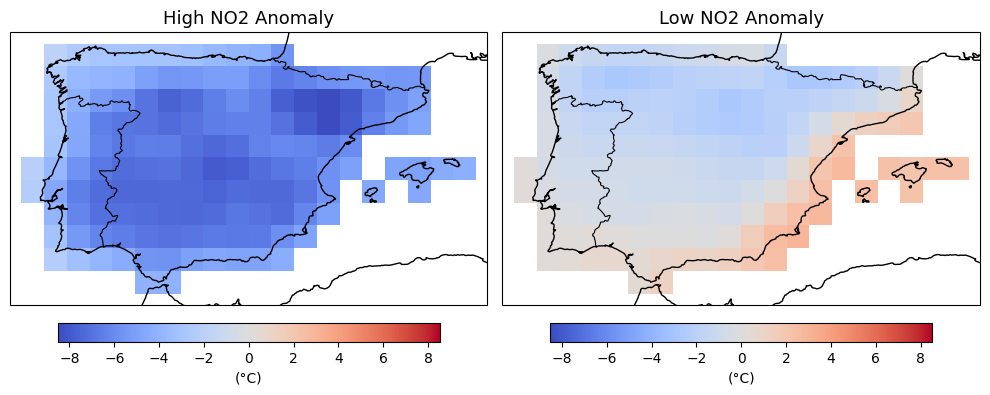

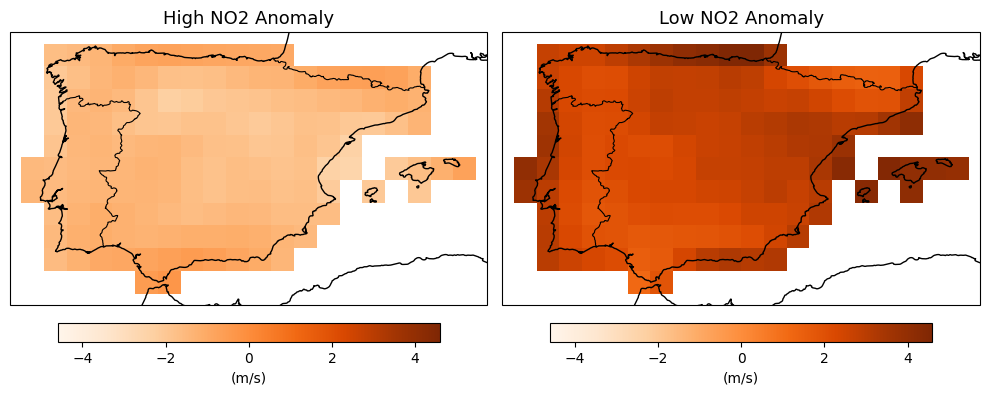

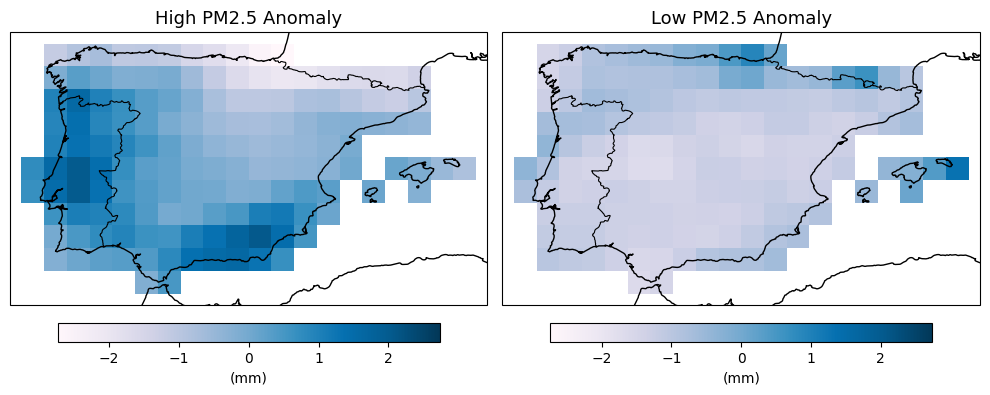

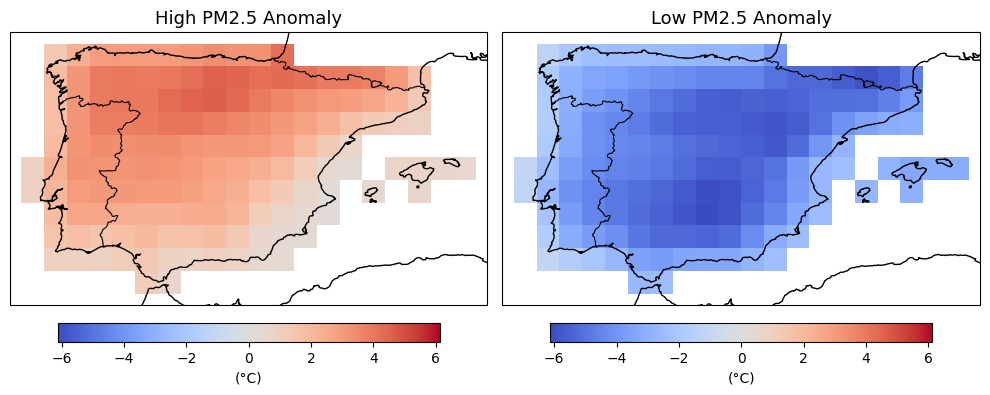

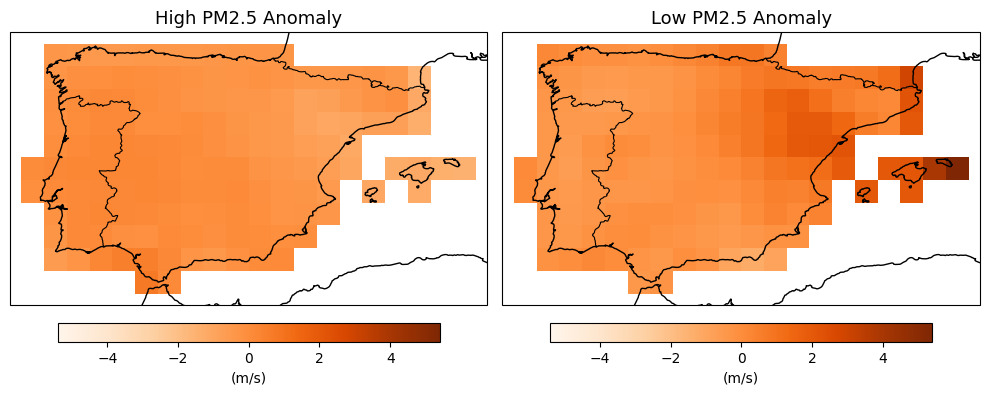

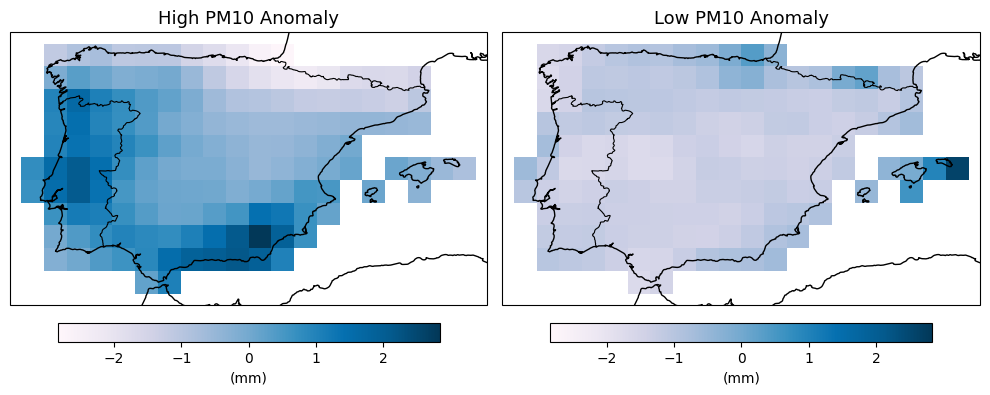

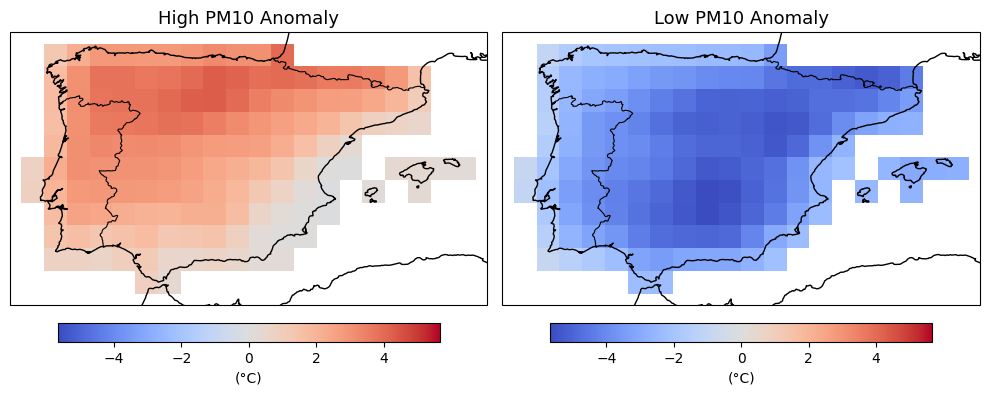

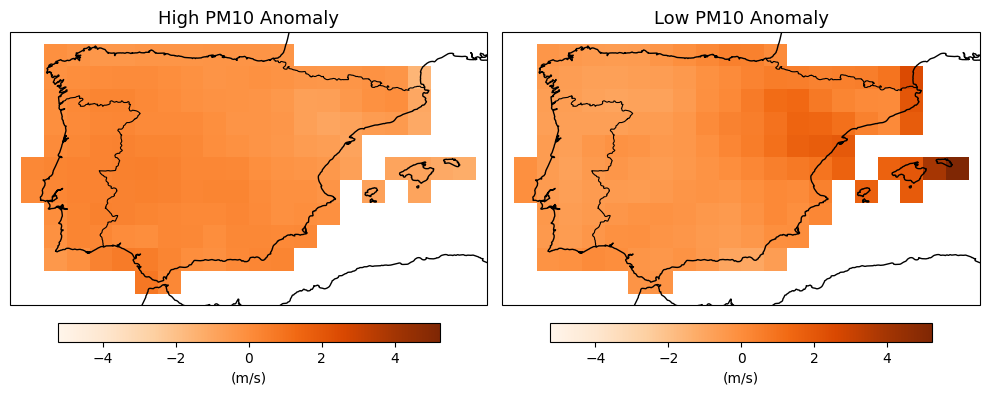


Code execution finished. Composites and Anomalies now plotted without difference fields.


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ------------------------------
# USER INPUTS
# ------------------------------

pollutant_files = {
    'CO':    r"D:\IPMA\Results\co_fire_meteo_Greece.nc",
    'NO':    r"D:\IPMA\Results\no_fire_meteo_Greece.nc",
    'NO2':   r"D:\IPMA\Results\no2_fire_meteo_Greece.nc",
    'PM2.5': r"D:\IPMA\Results\pm2p5_fire_meteo_Greece.nc",
    'PM10':  r"D:\IPMA\Results\pm10_fire_meteo_Greece.nc"
}

N_days = 25

meteo_vars = {
    "precip_Total_Precipitation": ("mm", "PuBu"),
    "temp_Max": ("°C", "coolwarm"),
    "wind_Max": ("m/s", "Oranges")
}

meteo_var_names = {
    "precip_Total_Precipitation": "Total Precipitation",
    "temp_Max": "Max Temperature",
    "wind_Max": "Max Wind Speed"
}

global_mean_output_file = r"D:\IPMA\Results\global_mean_meteo_Greece.nc" 
composite_output_dir = r"D:\IPMA\Results"

# --- Helper functions ---
def apply_unit_conversions(ds, pollutant_name):
    if pollutant_name == 'CO' and 'Mean' in ds:
        ds['Mean'] = ds['Mean'] * 1000
        if 'units' in ds['Mean'].attrs and ds['Mean'].attrs['units'] == 'mg/m3':
            ds['Mean'].attrs['units'] = 'µg/m3'
    
    precip_var = "precip_Total_Precipitation"
    if precip_var in ds:
        ds[precip_var] = ds[precip_var] * 1000
        if 'units' in ds[precip_var].attrs and ds[precip_var].attrs['units'] == 'm':
            ds[precip_var].attrs['units'] = 'mm'

    return ds

def set_composite_attrs(da, comp_type, var_name, pollutant, unit, N_days):
    da.name = f'{var_name}_{comp_type}'
    da.attrs['units'] = unit
    da.attrs['long_name'] = f'{comp_type} Composite of {meteo_var_names[var_name]} based on {pollutant} extremes'
    da.attrs['N_days'] = N_days
    return da

def calculate_dynamic_extent(data_array):
    mask = np.isfinite(data_array.values)
    if not mask.any(): return None

    lat_vals = data_array["latitude"].values
    lon_vals = data_array["longitude"].values

    valid_idx = np.where(mask)
    unique_lat_idx = np.unique(valid_idx[0])
    unique_lon_idx = np.unique(valid_idx[1])

    lat_step = lat_vals[1] - lat_vals[0] if len(lat_vals) > 1 else 0.5
    lon_step = lon_vals[1] - lon_vals[0] if len(lon_vals) > 1 else 0.5

    lat_min_ext = max(lat_vals[unique_lat_idx].min() - lat_step, lat_vals.min())
    lat_max_ext = min(lat_vals[unique_lat_idx].max() + lat_step, lat_vals.max())
    lon_min_ext = max(lon_vals[unique_lon_idx].min() - lon_step, lon_vals.min())
    lon_max_ext = min(lon_vals[unique_lon_idx].max() + lon_step, lon_vals.max())
    
    return [lon_min_ext, lon_max_ext, lat_min_ext, lat_max_ext]

# ------------------------------
# PART 1: GLOBAL MEAN CALCULATION
# ------------------------------

print("--- Part 1: Calculating & Saving Global Mean (Climatology) ---")
reference_pollutant = 'CO'
reference_file = pollutant_files[reference_pollutant]

try:
    ds_ref = xr.open_dataset(reference_file)
except FileNotFoundError:
    print(f"ERROR: Reference file not found at {reference_file}. Exiting.")
    exit()

ds_ref = apply_unit_conversions(ds_ref, reference_pollutant)
global_means = {}
for var_name, (unit, cmap) in meteo_vars.items():
    mean_da = ds_ref[var_name].mean(dim='time')
    mean_da.attrs['units'] = unit
    mean_da.attrs['long_name'] = f'Time-Mean of {meteo_var_names[var_name]}'
    global_means[var_name] = mean_da

ds_global_mean = xr.Dataset(global_means)
output_dir = os.path.dirname(global_mean_output_file)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
ds_global_mean.to_netcdf(global_mean_output_file, mode='w')
print(f"Global Mean data successfully saved to {global_mean_output_file}.")

# ------------------------------
# PART 2: COMPOSITING & ANOMALY CALCULATION
# ------------------------------

print("\n--- Part 2: Compositing Analysis and Saving Composites ---")
if not os.path.exists(composite_output_dir):
    os.makedirs(composite_output_dir)

all_composite_results = {}

for target_pollutant, target_file in pollutant_files.items():
    
    try:
        ds = xr.open_dataset(target_file)
    except FileNotFoundError:
        print(f"Skipping {target_pollutant}: File not found at {target_file}")
        continue
        
    ds = apply_unit_conversions(ds, target_pollutant)
        
    pollutant_time_series = ds['Mean'].mean(dim=['latitude', 'longitude'])
    ranked_series = pollutant_time_series.to_series().sort_values(ascending=False)
    high_days_time_stamps = ranked_series.index[:N_days]
    low_days_time_stamps = ranked_series.index[-N_days:]

    # --------------------------------------------------
    # PRINT RANGE OF POLLUTANT CONCENTRATIONS (High / Low)
    # --------------------------------------------------

    # Extract pollutant concentrations for selected days
    high_vals = ds['Mean'].sel(time=high_days_time_stamps)
    low_vals  = ds['Mean'].sel(time=low_days_time_stamps)

    # Spatial mean for each selected day
    high_vals_mean = high_vals.mean(dim=['latitude', 'longitude'])
    low_vals_mean  = low_vals.mean(dim=['latitude', 'longitude'])

    # Compute ranges
    high_min = float(high_vals_mean.min().values)
    high_max = float(high_vals_mean.max().values)
    low_min  = float(low_vals_mean.min().values)
    low_max  = float(low_vals_mean.max().values)

    units = ds['Mean'].attrs.get('units', 'unknown')

    print(f"\n[{target_pollutant}] Pollutant concentration ranges (N={N_days})")
    print(f"  High days: min = {high_min:.2f}, max = {high_max:.2f} ({units})")
    print(f"  Low  days: min = {low_min:.2f}, max = {low_max:.2f} ({units})")


    composite_data_vars = {} 
    composite_results_pollutant = {}

    for var_name, (unit, cmap) in meteo_vars.items():
        
        # Composites
        high_composite = ds[var_name].sel(time=high_days_time_stamps).mean(dim='time')
        low_composite = ds[var_name].sel(time=low_days_time_stamps).mean(dim='time')
        
        # Anomalies
        global_mean_data = global_means[var_name]
        high_anomaly = high_composite - global_mean_data 
        low_anomaly = low_composite - global_mean_data  

        # Store results for plotting
        composite_results_pollutant[var_name] = {
            'High_Comp': high_composite, 
            'Low_Comp': low_composite,   
            'High_Anomaly': high_anomaly,
            'Low_Anomaly': low_anomaly,
            'unit': unit,
            'cmap': cmap
        }

        # Store all generated fields for NetCDF saving
        composite_data_vars[f'{var_name}_High_Comp'] = set_composite_attrs(high_composite.copy(), 'High_Comp', var_name, target_pollutant, unit, N_days)
        composite_data_vars[f'{var_name}_Low_Comp'] = set_composite_attrs(low_composite.copy(), 'Low_Comp', var_name, target_pollutant, unit, N_days)
        composite_data_vars[f'{var_name}_High_Anom'] = set_composite_attrs(high_anomaly.copy(), 'High_Anom', var_name, target_pollutant, unit, N_days)
        composite_data_vars[f'{var_name}_Low_Anom'] = set_composite_attrs(low_anomaly.copy(), 'Low_Anom', var_name, target_pollutant, unit, N_days)

    all_composite_results[target_pollutant] = composite_results_pollutant
    
    # Save composites to NetCDF
    composite_file_name = f"{target_pollutant}_composite_meteo_Greece.nc"
    output_path = os.path.join(composite_output_dir, composite_file_name)
    ds_composite = xr.Dataset(
        composite_data_vars,
        coords={'latitude': high_composite['latitude'], 'longitude': high_composite['longitude']}
    )
    ds_composite.attrs['title'] = f'Composite Analysis for {target_pollutant} Extremes (N={N_days})'
    ds_composite.to_netcdf(output_path, mode='w')
    
print("Data processing complete. Starting visualizations.")

# ------------------------------
# PART 3: VISUALIZATION
# ------------------------------

print("\n--- Part 3: Generating Visualization Plots ---")
num_cols = len(meteo_vars)
meteo_list = list(meteo_vars.keys())

reference_data_for_extent = ds_global_mean[meteo_list[0]]
global_extent = calculate_dynamic_extent(reference_data_for_extent)
if global_extent is None:
    global_extent = [ds_global_mean.longitude.min().item(), ds_global_mean.longitude.max().item(), 
                     ds_global_mean.latitude.min().item(), ds_global_mean.latitude.max().item()]
    
TITLE_FONT_SIZE = 15
SUBTITLE_FONT_SIZE = 13
AXIS_FONT_SIZE = 11
CBAR_FONT_SIZE = 10

# --- Global Mean Climatologies ---
fig1, axes1 = plt.subplots(
    1, num_cols, figsize=(4 * num_cols, 3.5),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
if num_cols == 1: axes1 = [axes1]

for i, var_name in enumerate(meteo_list):
    ax = axes1[i]
    mean_data = global_means[var_name]
    unit, cmap = meteo_vars[var_name]
    var_display_name = meteo_var_names[var_name]
    
    plot = mean_data.plot.pcolormesh(
        ax=ax, x='longitude', y='latitude', cmap=cmap, 
        transform=ccrs.PlateCarree(), add_colorbar=False, rasterized=True
    )
    ax.set_extent(global_extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.8)
    ax.set_title(f"{var_display_name}", fontsize=SUBTITLE_FONT_SIZE) 
    ax.set_xlabel("Longitude", fontsize=AXIS_FONT_SIZE)
    ax.set_ylabel("Latitude", fontsize=AXIS_FONT_SIZE)
    
    cbar = plt.colorbar(plot, ax=ax, orientation='horizontal', pad=0.08, aspect=40,
                        label=f'({unit})', shrink=0.7)
    cbar.locator = MaxNLocator(nbins=8)
    cbar.update_ticks()
    cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar.set_label(f"({unit})", fontsize=CBAR_FONT_SIZE)
    cbar.ax.tick_params(labelsize=CBAR_FONT_SIZE)

fig1.suptitle("Global Mean Climatology of Meteorological Variables", fontsize=TITLE_FONT_SIZE, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Raw Composites ---
for pollutant in pollutant_files.keys():
    if pollutant not in all_composite_results: continue
    for var_name in meteo_list:
        result = all_composite_results[pollutant][var_name]
        high_comp = result['High_Comp']
        low_comp = result['Low_Comp']
        unit, cmap = result['unit'], meteo_vars[var_name][1]
        var_display_name = meteo_var_names[var_name]
        
        max_val = np.nanmax([high_comp.values, low_comp.values])
        min_val = np.nanmin([high_comp.values, low_comp.values])
        
        fig, axes = plt.subplots(
            1, 2, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}
        )
        
        # High Composite
        ax_high = axes[0]
        plot_high = high_comp.plot.pcolormesh(
            ax=ax_high, x='longitude', y='latitude', cmap=cmap, 
            vmin=min_val, vmax=max_val, add_colorbar=False,
            transform=ccrs.PlateCarree(), rasterized=True
        )
        ax_high.set_extent(global_extent, crs=ccrs.PlateCarree())
        ax_high.coastlines()
        ax_high.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax_high.set_title(f"High {pollutant} Composite", fontsize=SUBTITLE_FONT_SIZE)
        ax_high.set_xlabel("Longitude", fontsize=AXIS_FONT_SIZE)
        ax_high.set_ylabel("Latitude", fontsize=AXIS_FONT_SIZE)
        cbar_high = plt.colorbar(plot_high, ax=ax_high, orientation='horizontal', shrink=0.8, pad=0.05)
        cbar_high.set_label(f'({unit})', fontsize=CBAR_FONT_SIZE)
        
        # Low Composite
        ax_low = axes[1]
        plot_low = low_comp.plot.pcolormesh(
            ax=ax_low, x='longitude', y='latitude', cmap=cmap, 
            vmin=min_val, vmax=max_val, add_colorbar=False,
            transform=ccrs.PlateCarree(), rasterized=True
        )
        ax_low.set_extent(global_extent, crs=ccrs.PlateCarree())
        ax_low.coastlines()
        ax_low.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax_low.set_title(f"Low {pollutant} Composite", fontsize=SUBTITLE_FONT_SIZE)
        ax_low.set_xlabel("Longitude", fontsize=AXIS_FONT_SIZE)
        ax_low.set_ylabel("")
        cbar_low = plt.colorbar(plot_low, ax=ax_low, orientation='horizontal', shrink=0.8, pad=0.05)
        cbar_low.set_label(f'({unit})', fontsize=CBAR_FONT_SIZE)

        fig.suptitle( f"{var_display_name}", fontsize=TITLE_FONT_SIZE )

        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

# --- Composite Anomalies ---
for pollutant in pollutant_files.keys():
    if pollutant not in all_composite_results: continue
    for var_name in meteo_list:
        result = all_composite_results[pollutant][var_name]
        high_anomaly = result['High_Anomaly']
        low_anomaly = result['Low_Anomaly']
        unit, cmap = result['unit'], result['cmap']  # <-- Use cmap from meteo_vars
        var_display_name = meteo_var_names[var_name]
        
        # Use symmetric range around zero for anomalies
        max_abs = np.nanmax(np.abs([high_anomaly.values, low_anomaly.values])) if high_anomaly.values.size > 0 else 1e-6
        
        fig, axes = plt.subplots(
            1, 2, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()}
        )
        
        # High Anomaly
        ax_high = axes[0]
        plot_high = high_anomaly.plot.pcolormesh(
            ax=ax_high, x='longitude', y='latitude', cmap=cmap,  # <-- replaced RdBu_r
            vmin=-max_abs, vmax=max_abs, add_colorbar=False,
            transform=ccrs.PlateCarree(), rasterized=True
        )
        ax_high.set_extent(global_extent, crs=ccrs.PlateCarree())
        ax_high.coastlines()
        ax_high.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax_high.set_title(f"High {pollutant} Anomaly", fontsize=SUBTITLE_FONT_SIZE)
        ax_high.set_xlabel("Longitude", fontsize=AXIS_FONT_SIZE)
        ax_high.set_ylabel("Latitude", fontsize=AXIS_FONT_SIZE)
        cbar_high = plt.colorbar(plot_high, ax=ax_high, orientation='horizontal', shrink=0.8, pad=0.05)
        cbar_high.set_label(f'({unit})', fontsize=CBAR_FONT_SIZE)
        
        # Low Anomaly
        ax_low = axes[1]
        plot_low = low_anomaly.plot.pcolormesh(
            ax=ax_low, x='longitude', y='latitude', cmap=cmap,  # <-- replaced RdBu_r
            vmin=-max_abs, vmax=max_abs, add_colorbar=False,
            transform=ccrs.PlateCarree(), rasterized=True
        )
        ax_low.set_extent(global_extent, crs=ccrs.PlateCarree())
        ax_low.coastlines()
        ax_low.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax_low.set_title(f"Low {pollutant} Anomaly", fontsize=SUBTITLE_FONT_SIZE)
        ax_low.set_xlabel("Longitude", fontsize=AXIS_FONT_SIZE)
        ax_low.set_ylabel("")
        cbar_low = plt.colorbar(plot_low, ax=ax_low, orientation='horizontal', shrink=0.8, pad=0.05)
        cbar_low.set_label(f'({unit})', fontsize=CBAR_FONT_SIZE)

        fig.suptitle( f"{var_display_name}", fontsize=TITLE_FONT_SIZE )

        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

print("\nCode execution finished. Composites and Anomalies now plotted without difference fields.")
